This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


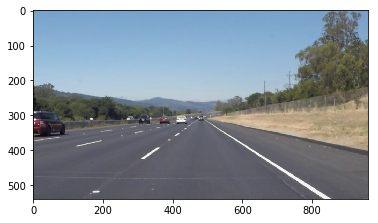

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

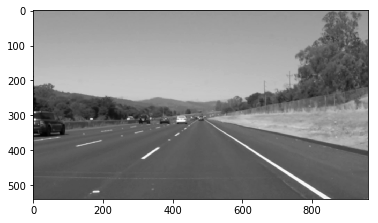

In [2]:
# Gray scale conversion, gaussian filter and display
image_gray = grayscale(image)
#plt.imshow(image_gray, cmap='gray')

image_filtered = gaussian_blur(image_gray,5)
plt.imshow(image_filtered, cmap='gray')


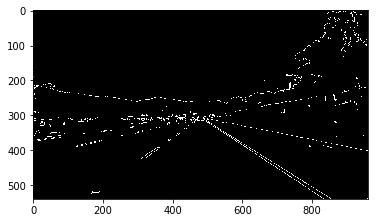

In [3]:
image_canny = canny(image_gray, 100, 200) # 100, 200 )
plt.imshow(image_canny, cmap='gray')

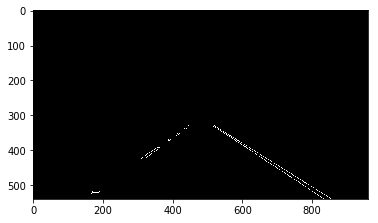

In [4]:
imshape = image_canny.shape
y_min = 330 # horizontal cut of the zone of interest - will be used in the last part to delimitate the drawn line
verticles = np.array([[(90,imshape[0]),(400, y_min), (imshape[1]-400, y_min), (imshape[1]-50,imshape[0])]], dtype=np.int32)
image_interest = region_of_interest(image_canny,verticles)
plt.imshow(image_interest, cmap='gray')

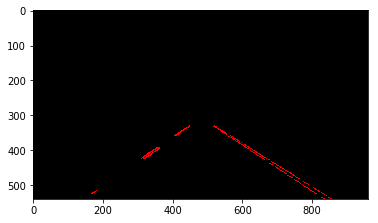

In [5]:
rho = 2
theta = 1
threshold = 10
min_line_len = 5
max_line_gap =10

image_hough = hough_lines(image_interest, rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(image_hough, cmap='gray')

In [16]:
#draw left and right lines
lines = cv2.HoughLinesP(image_interest, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
print(type(lines),lines.shape,lines.dtype)
#lines_left=np.zeros((1,1,4),dtype=lines.dtype)
left=[]
right=[]
slope_left_sum = 0   # sum of all the slopes values for the left lanes to compute the average left slope
slope_right_sum = 0  # same for right
offset_left_sum = 0  # sum of all the offset (b) values for the left lanes to compute the average left line offset
offset_right_sum = 0 # same for right
print(type(lines[0][:][:]))
#print(lines)

for i in range(0,lines.shape[0]):
    #if x1=x2 then the line is vertical and can be ignored
    #if y1=y2 then the line is horizontal and can be ignored
    if((lines[i][0][2]!=lines[i][0][0]) & (lines[i][0][1]!=lines[i][0][3])):   
        slope = (lines[i][0][3]-lines[i][0][1])/(lines[i][0][2]-lines[i][0][0])
        if (slope > 0):
            right.append(lines[i][:][:])
            slope_right_sum = slope_right_sum + slope
            offset_right_sum = offset_right_sum + (lines[i][0][1] - slope*lines[i][0][0])  # b = y1-ax1
            print(lines[i][0][0],lines[i][0][1],lines[i][0][2],lines[i][0][3])
            print(slope)
            print(lines[i][0][1] - slope*lines[i][0][0])
            print(lines[i][0][3] - slope*lines[i][0][2])

        else:
            left.append(lines[i][:][:])
            slope_left_sum = slope_left_sum + slope
            offset_left_sum = offset_left_sum + (lines[i][0][1] - slope*lines[i][0][0])  # b = y1-ax1

#print(lines_left)
#print(len(lines_left))

lines_left=np.array(left)
lines_right=np.array(right)

print('detected left lines  ',type(lines_left),lines_left.shape)
print('detected right lines  ',type(lines_right),lines_right.shape)
       


<class 'numpy.ndarray'> (84, 1, 4) int32
<class 'numpy.ndarray'>
544 350 556 356
0.5
78.0
78.0
654 422 662 426
0.5
95.0
95.0
730 472 738 476
0.5
107.0
107.0
714 452 726 458
0.5
95.0
95.0
597 384 605 388
0.5
85.5
85.5
741 469 751 474
0.5
98.5
98.5
752 476 764 482
0.5
100.0
100.0
629 399 639 404
0.5
84.5
84.5
636 410 644 414
0.5
92.0
92.0
574 369 582 373
0.5
82.0
82.0
829 524 841 530
0.5
109.5
109.5
578 367 588 372
0.5
78.0
78.0
773 489 785 495
0.5
102.5
102.5
648 418 656 422
0.5
94.0
94.0
753 487 763 492
0.5
110.5
110.5
735 465 745 470
0.5
97.5
97.5
826 535 835 539
0.444444444444
167.888888889
167.888888889
522 335 547 347
0.48
84.44
84.44
573 364 585 370
0.5
77.5
77.5
777 503 787 508
0.5
114.5
114.5
580 373 590 378
0.5
83.0
83.0
516 331 541 343
0.48
83.32
83.32
805 509 817 515
0.5
106.5
106.5
640 406 650 411
0.5
86.0
86.0
630 406 638 410
0.5
91.0
91.0
642 414 650 418
0.5
93.0
93.0
651 413 661 418
0.5
87.5
87.5
527 339 558 354
0.483870967742
84.0
84.0
788 510 796 514
0.5
116.0
116.0
563

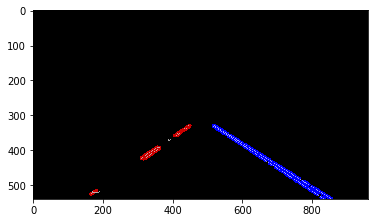

In [12]:
line_image_right = np.copy(image)*0 #creating a blank to draw lines on
line_image_left = np.copy(image)*0 #creating a blank to draw lines on

#Draw left lines
for line in lines_left:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_left,(x1,y1),(x2,y2),(255,0,0),10)
#Draw right lines
for line in lines_right:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image_right,(x1,y1),(x2,y2),(0,0,255),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((image_interest,image_interest,image_interest)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image_left, 1, 0) 
combo = cv2.addWeighted(combo, 0.8, line_image_right, 1, 0)
plt.imshow(combo)

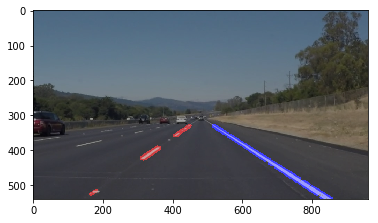

In [13]:
image_2 = np.copy(image) #copy orginal image to combine with detected lanes

#combine lines to original image
combo_2 = cv2.addWeighted(image_2, 0.8, line_image_left, 1, 0) 
combo_2 = cv2.addWeighted(combo_2, 0.8, line_image_right, 1, 0)
plt.imshow(combo_2)

Equation of left lane is: y =  -0.657601251274 *x +  630.146090176
7107.14888889
Equation of right lane is: y =  0.496730565551 *x +  97.3582039574
-1.15111104699
456 330 137 540
468 330 891 540


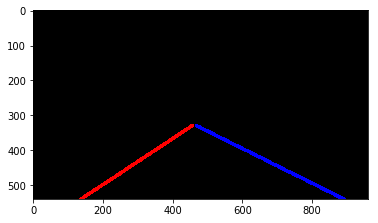

In [14]:
line_image = np.copy(image)*0 #creating a blank to draw lines on
# Averaging lines
#left line equation average
if(lines_left.shape[0]!=0):
    slope_left = slope_left_sum/lines_left.shape[0]
    offset_left = offset_left_sum/lines_left.shape[0]
    y_min_left = y_min #minimum y value from the zone of interest
else: # no left lanes detectected
    slope_left = 0
    offset_left = 0 
    x_min_left = 0
    y_min_left=0
print('Equation of left lane is: y = ',slope_left,'*x + ',offset_left)

#right line equation average
if(lines_right.shape[0]!=0):
    print(offset_right_sum)
    slope_right = slope_right_sum/lines_right.shape[0]
    offset_right = offset_right_sum/lines_right.shape[0]
    y_min_right = y_min #minimum y value from the zone of interest
else: # no right lanes detectected
    slope_right = 0
    offset_right = 0   
    x_min_right = 0
    y_min_right=0
print('Equation of right lane is: y = ',slope_right,'*x + ',offset_right)

#compute the x value for the horizontal limit of the left line according to the zone of interest
y_max = image.shape[0]
x_min_left = int((y_min_left-offset_left)/slope_left) # x = [y-b]/a
x_max_left = int((y_max-offset_left)/slope_left) # x = [y-b]/a
x_min_right = int((y_min_right-offset_right)/slope_right) # x = [y-b]/a
x_max_right = int((y_max-offset_right)/slope_right) # x = [y-b]/a

print(slope_left*image.shape[1]+offset_left)
print(x_min_left,y_min_left,x_max_left,y_max)
print(x_min_right,y_min_right,x_max_right,y_max)
cv2.line(line_image, (x_max_left,y_max), (x_min_left, y_min_left), (255,0,0), 10)
cv2.line(line_image, (x_max_right,y_max), (x_min_right, y_min_right), (0,0,255), 10)

plt.imshow(line_image)
#compute the x value for the horizontal limit of the right line according to the zone of interest
#x_min_left = (y_min_right-offset_right)/slope_right 
#cv2.line(line_image, (image.shape[1], slope_right*image.shape[1]+offset_right), (x_min_right, y_min_right), [0,0,255], 10)

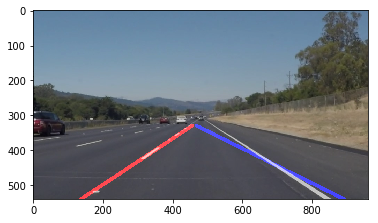

In [15]:
image_res = np.copy(image)
combo_res = cv2.addWeighted(image_res, 0.8, line_image, 1, 0)
plt.imshow(combo_res)